In [212]:
%matplotlib inline
from math import log
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
# For the infomap algorithm. Use `pip install infomap`
from infomap import Infomap

In [177]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from community import community_louvain

# Question 1
## Dynamics, time-scales and Communities

### (a) Ex.VII.1 : 
Write a code to simulate consensus dynamics on a network, and verify that the dynamics asymptotically converges towards the state 

\begin{equation}
x_∗ = \mathbf{1}^T \mathbf{x}_0/n.
\end{equation}

### Solution:

Recall consensus dynamics on graph with adjacency matrix $A$ is defined as

\begin{equation}
\dot{x}_i = \sum_{j = 1}^n A_{ij} \left(x_j - x_i\right),
\end{equation}

or in matrix form as

\begin{equation}
\dot{\mathbf{x}} = - L \mathbf{x},
\end{equation}

where $\mathbf{x} \in \mathbb{R}^n$ is a vector of states associated with the $n$ nodes, and $L$ is the combinatorial graph Laplacian. Simple model for a population of agents that update their beliefs/opinions to be more alike their neighbours'.

In [123]:
# Use Zachary Karate Club
G = nx.karate_club_graph()
# Order (number of nodes) in graph
n = len(G.nodes())
# For reproducibility
np.random.seed(0)
# Intial state
x0 = np.random.rand(1, n)

# Laplacian matrix for G
L = nx.laplacian_matrix(G).todense()

# Simulate
x = x0
dt = 0.0001
t = 0.0
# How do we know this is long enough?
while t < 100:
    x = x - dt * np.dot(x, L)
    t += dt

# Inspect results
print("Final simulated states: {0}".format(x))
print("Theoretical final state: {0}".format(np.sum(x0) / n))

Final simulated states: [[0.57344069 0.57344069 0.57344069 0.57344069 0.57344069 0.57344069
  0.57344069 0.57344069 0.57344069 0.57344069 0.57344069 0.57344069
  0.57344069 0.57344069 0.57344069 0.57344069 0.57344069 0.57344069
  0.57344069 0.57344069 0.57344069 0.57344069 0.57344069 0.57344069
  0.57344069 0.57344069 0.57344069 0.57344069 0.57344069 0.57344069
  0.57344069 0.57344069 0.57344069 0.57344069]]
Theoretical final state: 0.5734406891606043


#### How long did we need to simulate for?

Can use properties of Laplacian to get an idea. For a connected, undirected graph, $L$ is real and symmetric; thus

\begin{equation}
L = V \Lambda V^T = \sum_{i=1}^n \lambda \mathbf{v}_i \mathbf{v}^T_i,
\end{equation}

where $V = (\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_n)$ is the matrix whose columns are eigenvectors of $L$ and $\Lambda = \text{diag}\left(\lambda_1, \lambda_2, \dots, \lambda_n \right)$. (See end of notebook if latter equality unfamiliar.)

Since the solution to $\dot{\mathbf{x}} = -L \mathbf{x}$ is $\mathbf{x}(t) = \exp(-Lt) \mathbf{x}_0$, and since

\begin{equation}
\exp(-Lt) = \sum_{i} \exp(-\lambda_i t) \mathbf{v}_{i} \mathbf{v}^T_i
\end{equation}

(for the same reason that $L$ is of this form), we have that

\begin{equation}
\mathbf{x}(t) = \frac{\mathbf{1} \mathbf{x}_0}{n} + \exp(-\lambda_2 t) \mathbf{v}_2 \mathbf{v}^T_2 \mathbf{x}_0 + \dots
\end{equation}

where $0 = \lambda_1 < \lambda_2 \leq \dots \leq \lambda_n$ and $\mathbf{1}$ is the square matrix of 1s. Thus the persistent eigenmode is the one corresponding to the zero eigenvalue, while the next most persistent is the one corresponding to the smallest non-zero eigenvalue $\lambda_2$.

From this, simulating for a time $T \gg 1/\lambda_2$ is appropriate.

In [116]:
def get_consensus_timescale(L, n_components):

    # Find eigenvalues and eigenvectors of L
    vals, vecs = np.linalg.eig(L)
    # Find the eigenvalue
    l = np.sort(vals)[n_components]
    return 1./l

For our Zachary Karate Club, $T \gg$

In [117]:
get_consensus_timescale(L,1)

2.1343567923554656

### (b) Ex.VII.2
Write a code to reproduce the numerical results of Figure 23 in the lecture notes

/home/user/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


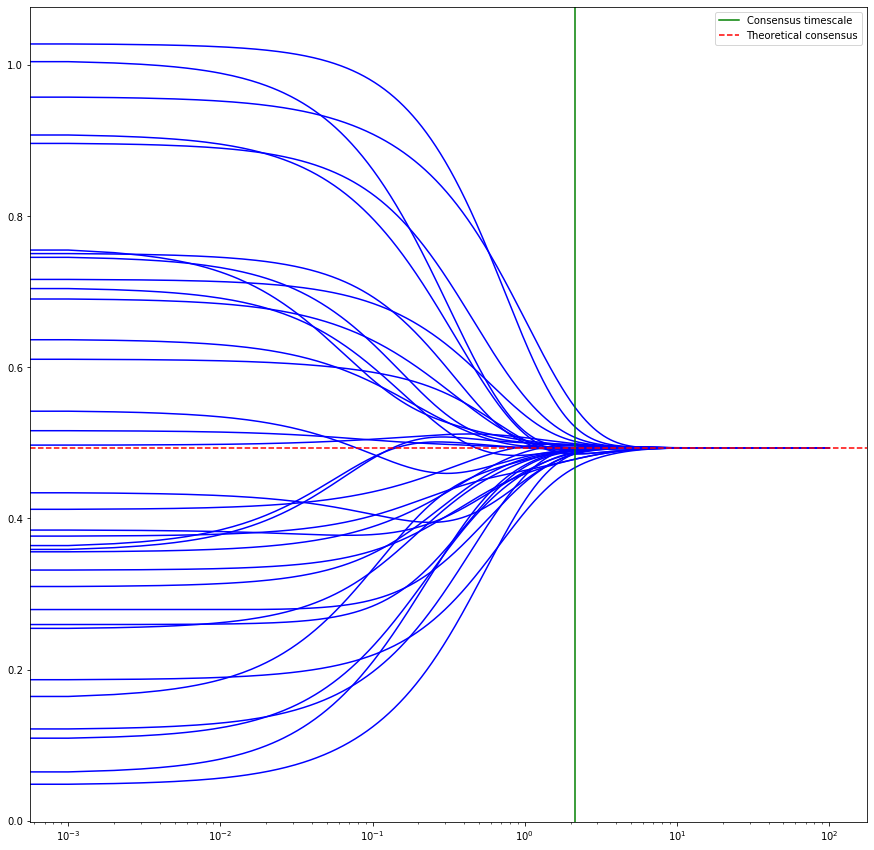

In [124]:
%matplotlib inline

# For reproducibility
np.random.seed(3)
# Initialise
x0 = []
for i in range (n):
    x0.append( random.random() + (i / 100) * 0.2 )
# Graph Laplacian
L = nx.laplacian_matrix(G).todense()

# This stores the dynamics for each node
dynamics_dic = {}
for i in range(n):
    dynamics_dic[i] = []

# Simulate
x = np.array(x0)
dt = 0.001
t = 0.0
times = []
while t < 100:
    times.append(t)
    for i in range(n):
        dynamics_dic[i].append(x.item(i))
    # Take a step
    x = x - dt * np.dot(x, L)
    t += dt   

# Plot
plt.figure(figsize=(15,15))
for i in range(n):
    plt.plot(times, dynamics_dic[i], "b")
plt.axvline(get_consensus_timescale(L, 1), c='g', label="Consensus timescale")
plt.axhline(np.mean(x0), ls='--', c='r', label="Theoretical consensus")

plt.xscale('log')
plt.legend()
plt.show()

#### Reproducing Figure 23

In [120]:
# For reproducibility
np.random.seed(10)
# Initialise graph object
n = 300
G = nx.Graph()
# Create nodes
G.add_nodes_from(range(n))

dynamics_dic = {}

# Add edges according to stochastic block matrix
for i in range(n):
    dynamics_dic[i] = []
    for j in range(i, n):
        if int(i / 100) == int(j / 100):
            p = 0.8  # p_in
        else:
            p = 0.02  # p_out
        if random.random() < p:
            G.add_edge(i, j)

# Initial conditions
x0 = []
for i in range(n):
    x0.append(random.random() + int(i / 100) * 0.2)
L = nx.laplacian_matrix(G).todense()

# Time evolution
x = np.array(x0)
dt = 0.001
t = 0.0
times = []
while t < 10:
    times.append(t)
    for i in range(n):
        dynamics_dic[i].append(x.item(i))
    x = x - dt * np.dot(x, L)
    t += dt

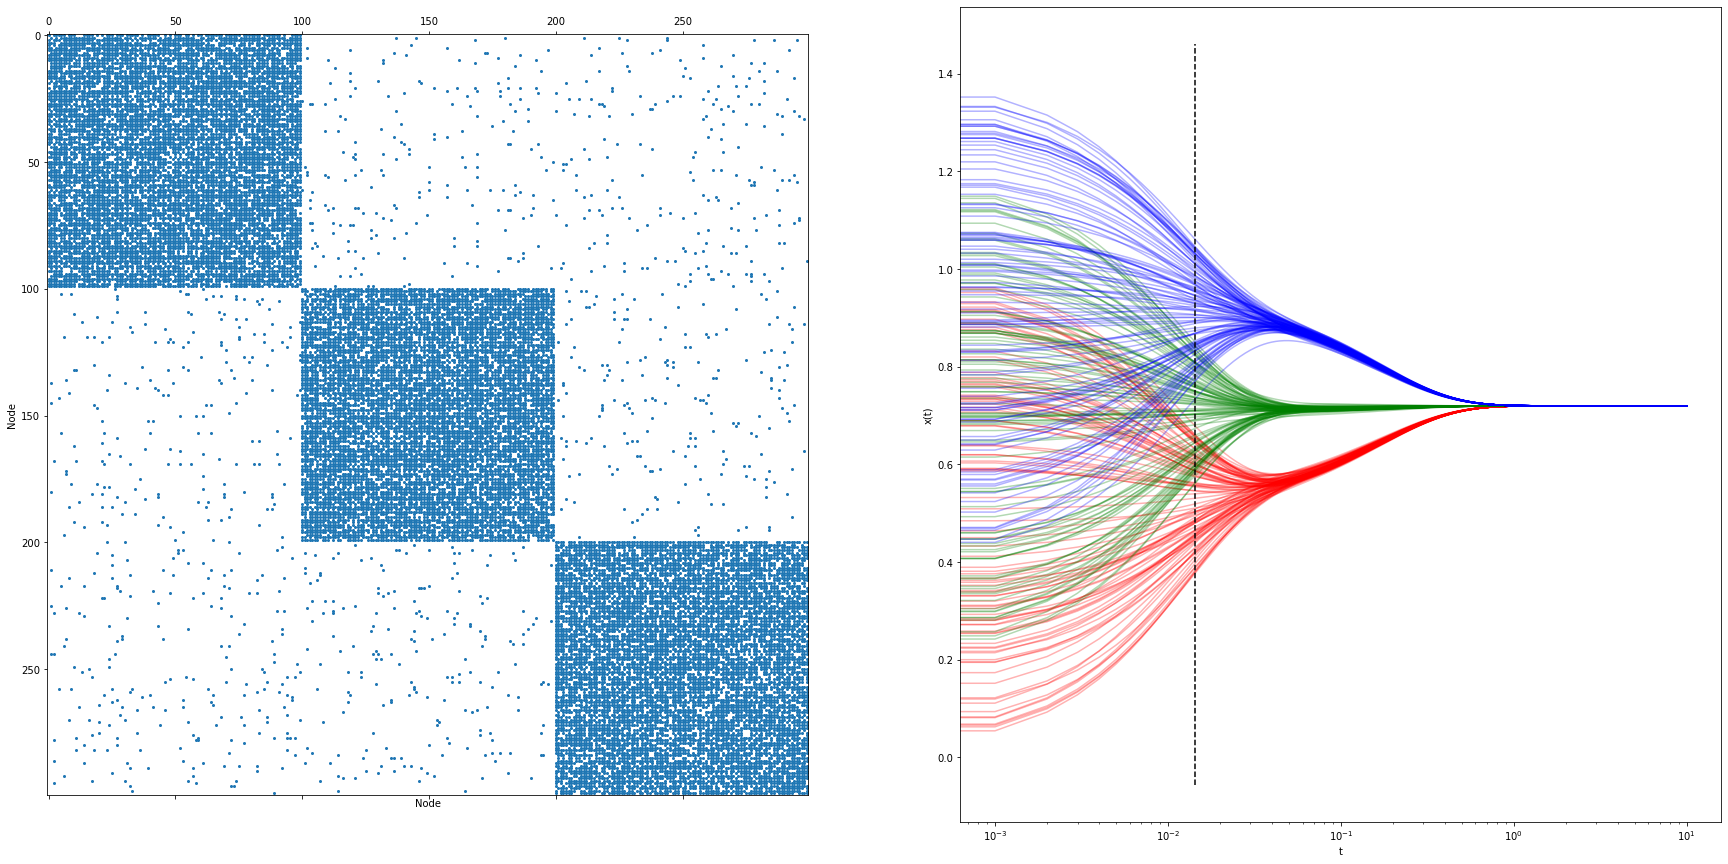

In [121]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Matrix
A = nx.adjacency_matrix(G)
ax1.spy(A, marker='o', ms=2, alpha=1)
ax1.set_xlabel('Node')
ax1.set_ylabel('Node')

# Consensus dynamics
alpha = 0.3  # transparency of lines
for i in range(100):
    ax2.plot(times, dynamics_dic[i], 'r', alpha=alpha)
for i in range(100, 200):
    ax2.plot(times, dynamics_dic[i], 'g', alpha=alpha)
for i in range(200, 300):
    ax2.plot(times, dynamics_dic[i], 'b', alpha=alpha)
ax2.set_xscale('log')
ax2.set_xlabel('t')
ax2.set_ylabel('x(t)')

# Compute characteristic time
L = nx.laplacian_matrix(G)
eigvals = np.linalg.eigvals(L.todense())
# spectral gap expected at 4th eigenvalue
lambda4 = np.sort(eigvals)[3]
t = 1 / lambda4
ymin, ymax = ax2.get_ylim() 
ax2.plot([t, t], [ymin, ymax], 'k--')

# Question 2
## Dynamics I: Random walks

### (a) Ex.VIII.1: 
Write your own code to calculate the Pagerank of a directed network. Test on an example
the dependency of Pagerank on the teleportation coefficient. Test your code on an undirected, connected,
regular network and comment the results.

Recall that PageRank is a measure of node importance in a graph. It models the trajectory of a random walker that moves to an adjacent node with probability $\alpha$ and teleports to some potentially non-adjacent node with probability $1 - \alpha$. In full:

\begin{equation}
p_{i}(t+1) = (1- \alpha) u_i + \alpha \sum_{j} p_{j}(t) T_{ji}, 
\end{equation}

where $p_i(t+1)$ is the probability that a random walker is at node $i$ at time $t+1$, $T_{ji} = p( j \to i | \text{ walker is at }j \text{, walker moves along an edge })$, and $u_i = p(\text{ walker teleports to }i | \text{ walker does not move along an edge })$. PageRank is then the stationary distribution for the above process.

In [ ]:
# PageRank function
def pageRank (G, alpha, u=None):
    # Get adjacency matrix from graph
    A = nx.adjacency_matrix(G)
    A = A.todense()
    # Compute transition matrix
    row_sums = np.sum(A, axis=1)
    # 1.0 * to make it a float
    T = A / (1.0 * row_sums)

    # Number of nodes
    n = len(G.nodes())
    # Personalisation vector: p( teleport to node i | teleporting )
    # Choose to be uniform across nodes
    if u is None:
        u = np.ones((1, n)) / n

    # Initial random walker probability vector
    p = np.ones((1, n)) / n
    # Find PageRank
    if not (alpha in [0., 1.]):
        for i in range (1000):
            p = alpha * np.dot(p, T) + (1 - alpha) * u
        return p
    elif alpha == 1.:
        for i in range (1000):
            p = np.dot(p, T)
        return p
    elif alpha == 0.:
        return u

In the cell below, we will compute PageRank for different graphs and for different $\alpha$. We'll plot the PageRank at each $\alpha$ for each graph, and we'll look at how changing $\alpha$ changes the ranking of nodes by PageRank and how the values of PageRank change with $\alpha$.


--- ER Graph ---
Rankings: [[ 0 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5
   4  3  2  1 28 29]]
Number of elements that are different: 0
Rankings: [[14 25  7 17 27  4 10  6 15 29 24 28  0  3  9  2  1 11 23 16 22  5 19 13
  20 26 21 12 18  8]]
Number of elements that are different: 29
Rankings: [[14 17  7 25 27 10  6  4 15 29  0 28 24  9  1  3  2 11 23 16 22  5 19 13
  20 26 21 12 18  8]]
Number of elements that are different: 11
Rankings: [[14 17  7 25 10 27  6 15  4  0 29 28  9 24  1 11  3  2 23 16 22  5 19 13
  20 26 21 12 18  8]]
Number of elements that are different: 11
Rankings: [[14 17  7 25 10 27  6 15  0  4 29 28  9  1 11 24  2  3 23 16 22  5 13 19
  20 26 21 12 18  8]]
Number of elements that are different: 9
Rankings: [[14  7 17 27 25 15 10  0  6 29  9 11  1 28  4 24  3 23  2 19 16 22  5 13
  20 26 18 12 21  8]]
Number of elements that are different: 24

--- ZKC ---
Rankings: [[ 0 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15  1  2  3  4  5  6

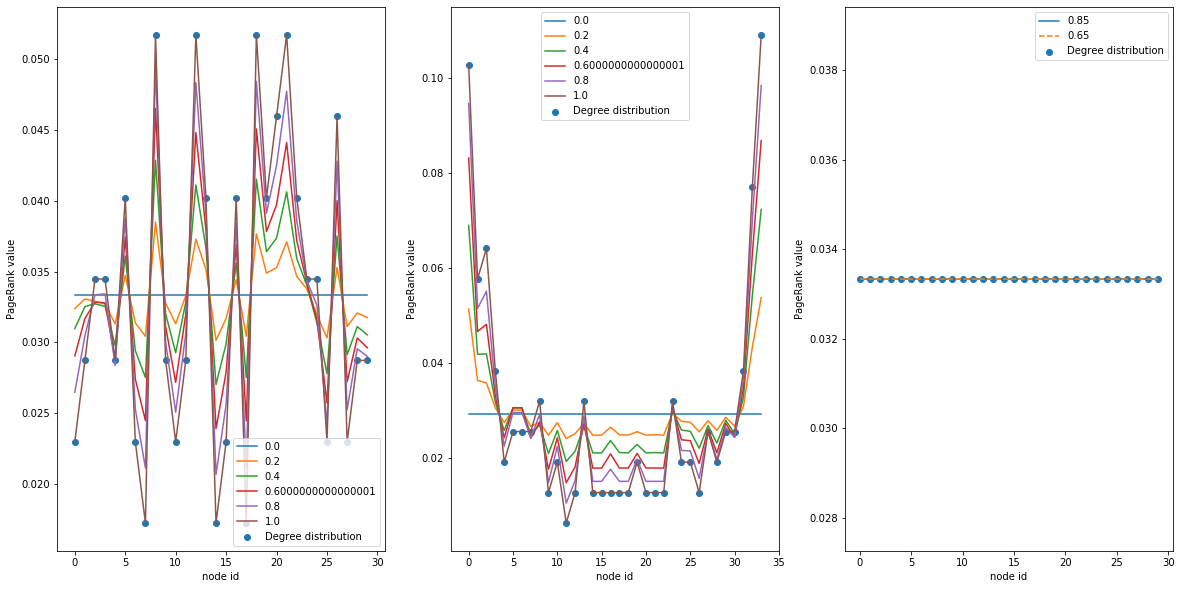

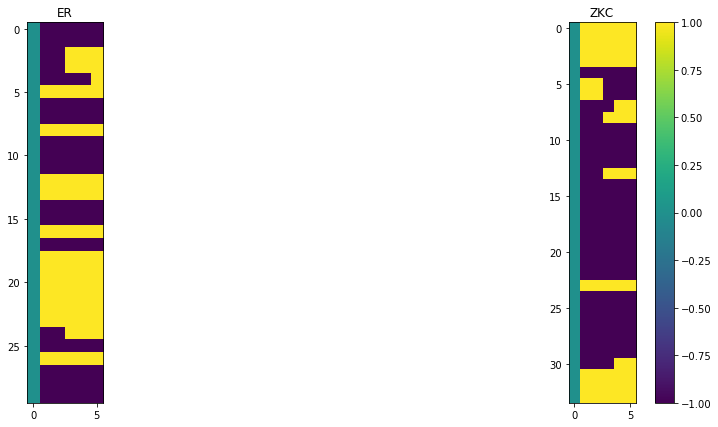

In [172]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
fig1, axes1 = plt.subplots(1,2, figsize=(15,7))

print("\n--- ER Graph ---")

# For reproducibility
random.seed(111)
# Create Erdos-renyi graph
G = nx.erdos_renyi_graph(30,0.2)

deg_dist = [G.degree(n)/(2*len(G.edges())) for n in range(G.order())]

argsort_old = None
p_old = None
alphas = np.arange(0, 1.00001, 0.2)
upnodown = np.zeros((G.order(), alphas.size))
# For different alpha, find and plot PageRanks
idx = 0
for alpha in alphas:
    # Compute PageRank
    p = pageRank(G, alpha)
    
    # Look at node rankings
    print("Rankings:", np.argsort(p))
    if argsort_old is None:
        argsort_old = np.argsort(p)
    print("Number of elements that are different:", np.sum(argsort_old != np.argsort(p)))
    axes[0].plot([p.item(ci) for ci in range(len(G.nodes()))], label=str(alpha))
    argsort_old = np.argsort(p)
    
    # Check for monotonicity
    if p_old is None:
        p_old = p
    them_changes = np.sign(p - p_old)
    upnodown[:, idx] = them_changes
    p_old = p
    idx += 1
    
axes[0].scatter(range(G.order()), deg_dist, label="Degree distribution")
axes[0].set_xlabel("node id")
axes[0].set_ylabel("PageRank value")
axes[0].legend()

# Inspect for monotonic changes in PageRank value as alpha increases
axes1[0].imshow(upnodown)
axes1[0].set_title("ER")

print("\n--- ZKC ---")

# Same again for ZKC
G = nx.karate_club_graph()
deg_dist = [G.degree(n)/(2*len(G.edges())) for n in range(G.order())]
argsort_old = None
p_old = None
alphas = np.arange(0, 1.00001, 0.2)
upnodown = np.zeros((G.order(), alphas.size))
idx = 0
for alpha in np.arange (0, 1.00001, 0.2):
    # Compute PageRank
    p = pageRank(G, alpha)
    
    # Look at node rankings
    print("Rankings:", np.argsort(p))
    if argsort_old is None:
        argsort_old = np.argsort(p)
    print("Number of elements that are different:", np.sum(argsort_old != np.argsort(p)))
    axes[1].plot([p.item(ci) for ci in range(len(G.nodes()))], label=str(alpha))
    argsort_old = np.argsort(p)
    
    # Check for monotonicity
    if p_old is None:
        p_old = p
    them_changes = np.sign(p - p_old)
    upnodown[:, idx] = them_changes
    p_old = p
    idx += 1
axes[1].scatter(range(G.order()), deg_dist, label="Degree distribution")
axes[1].set_xlabel("node id")
axes[1].set_ylabel("PageRank value")
axes[1].legend()

# Inspect for monotonic changes in PageRank value as alpha increases
cm = axes1[1].imshow(upnodown)
axes1[1].set_title("ZKC")
plt.colorbar(cm)

# Finally same again for a regular graph (all nodes have same degree)
G = nx.random_regular_graph(5, 30)
p = pageRank(G, 0.85)
p2 = pageRank(G, 0.65)
deg_dist = [G.degree(n)/(2*len(G.edges())) for n in range(G.order())]
axes[2].scatter(range(G.order()), deg_dist, label="Degree distribution")
axes[2].set_xlabel("node id")
axes[2].set_ylabel("PageRank value")
axes[2].plot([p.item(ci) for ci in range(len(G.nodes()))], "-", label=0.85)
axes[2].plot([p2.item(ci) for ci in range(len(G.nodes()))], "--", label=0.65)
#plt.ylim([0.033, 0.034])
axes[2].legend()
plt.show()

Not necessarily monotonic. Sometimes increase then decrease, sometimes opposite. Eqs. 183 - 185 in lecture notes give some analytic results for PageRank vector, and shows that varying $\alpha$ between 0 and 1 can drastically changes the PageRank distribution because higher order terms have more weight at higher $\alpha$. 

#### How to choose $\alpha$?

https://dl.acm.org/doi/pdf/10.1145/1629096.1629097 : talks about the problem of choosing $\alpha$. It was overlooked in the original PageRank publication, but it's important both for the actual values and the relative orderings of nodes in terms of their PageRanks (as sort of seen above).

Som considerations they raise: 
- PageRank is traditionally computed with power method, and number of iterations required for convergence grows with $\alpha$
- The closer $\alpha$ is to 1, the more numerical precision you need (in terms of floating point operations)
- Also don't want to $\alpha$ too close to 1 because it defeats the point of having that term there in the first place (you don't want your random walkers to get too stuck in recurrent states)

### (b) Ex.VIII.2: 
_By performing stochastic simulations of an ensemble of random walkers on a graph, verify
numerically Kac’s formula._

Kac's formula relates mean recurrence time $m_{ii}$ to the stationary probability distribution of random walkers. 

What is the mean recurrence time for node $i$? It is the average time (number of steps) required to return to $i$ after visiting it once. 

Kac's formula is:

$$ m_{ii} = \frac{1}{p_i^*}$$

In [ ]:
# Setup and simulation steps

# Our old friend
G = nx.karate_club_graph()
n = len(G.nodes())

#run the random walk
def step(G, node):
    return random.choice(list(G.neighbors(node)))
    
def retTime (G, node):
    steps = 0
    nnode = node
    # Count the number of steps in this simulation that were required to revisit the node once
    while (steps == 0) or (nnode != node):
        nnode = step(G, nnode)
        steps += 1
    return steps

In [7]:
# Run the simulation this many times for each node
repeat_num = 10000
m = [0.0] * n
for i in range(n):
    for j in range(repeat_num):
        m[i] += retTime(G, i)
    m[i] /= repeat_num

#solve p*
A = nx.adjacency_matrix(G)
A = A.todense()
row_sums = np.sum(A, axis=1)
T = A / (1.0 * row_sums)

# solve pT = p, by iterating (power method)
p = np.ones((1, n)) / n
for i in range(10000):
    p = np.dot(p, T)

# get difference between Kacs formula (1/p) and the mean return time m[i]
for i in range (n):
    print (p.item (i) * m[i] - 1)

-0.004728205128208485
-0.0072307692307727045
0.004634615384611962
0.00462307692307351
0.011001923076919828
0.012717948717945626
-0.013682051282054353
0.008130769230765944
-0.006038461538464768
-0.00048076923077255973
0.007271153846150735
0.0073512820512786625
-0.0020102564102598697
-0.004766025641028904
0.021719230769227327
0.0073025641025605825
0.0019205128205097566
-0.0010948717948753295
-0.013634615384618853
0.023524999999996687
-0.01006666666667011
0.007008974358970965
0.010299999999996423
0.00136538461538116
-0.0008557692307725739
0.009273076923073553
-0.005616666666670156
-0.016523076923080193
-0.006582692307695703
-0.009723076923080276
0.009792307692304325
0.003780769230765868
-0.007823076923080263
0.00016666666666331764


# Question 3

## Random walks to reveal network structure

### 3a) Propose and justify generalisation of Markov stability (Eq. 207 in lecture notes) for directed networks.

#### What is Markov stability?

It is a property of a partition of nodes: the probability that a random walker will be in same community after time $t$, where these probabilities are calculated using the stationary distirbution. It's a measure of clustering quality: high Markov stability $\to$ high probability of remaining within a single community after time $t$ $\to$ good clustering.

Explicitly: given partition of nodes into $m$ disjoint subsets $g_1, g_2, \dots, g_m$ and a random walk on the graph with stationary probability vector $p^*$, Markov stability

\begin{equation}
R(t) = \sum_{i,j=1}^N \left[(p_i^*e^{-L't})_{ij} - p_i^*p_j^* \right]\delta(g_i, g_j).
\end{equation}

First term is the aforementioned probability; second is the probability that two independent random walkers will be in $g_i$ at times $0$ and $t$. Note that $L'_{ij} = \delta_{ij} - A_{ij}/k_{j}$ for undirected graphs.

#### Generalisation?

Discussed on page 15, slides of Week 7: directed graphs have transition probability $A_{ij}/k_{j}^{out}$, where $k_{j}^{out}$ is the out-degree of node $j$. So

\begin{equation}
p_{i, n+1} = \sum_{j} \frac{A_{ij}}{k_j^{out}}p_{j,n}.
\end{equation}

Can substitute directly into equation for Markov stability above to get 1-step Markov stability:

\begin{equation}
R(1) = \sum_{i,j} \left[ \frac{A_{ij}}{k_j^{out}}\pi_j - \pi_i \pi_j \right]\delta(g_i, g_j) \neq Q
\end{equation}

with $\pi_i = p^*_i$ for the directed case.

For directed networks must consider $L = I - D_{out}^{-1}A$.

The above assumes a unique stationary probability distribution, but this isn't always the case (i.e. the graph could be disconnected).

### 3b) Comparing clustering

The paper proposes an information theoretic criterion for comparing two partitions of a dataset (in our case, networks), called the **variation of information**. The logic is as follows:

* Consider a partition of $n$ nodes into clusters $C_1, ..., C_m$, each cluster of size $n_i$.
* The probability of a node being in cluster $C_k$ is
$$
P(k) = \frac{n_k}{n}.
$$
* The entropy associated our clustering $C_1, ..., C_m$ is:
$$
H(C) = - \sum_{k=1}^m P(k)\log(P(k)).
$$

Consider two clusterings: $C_1, ..., C_m$ and $C'_1, ..., C'_m$. If I randomly pick a node in $C_k$, in which cluster will it be in the other clustering? What is the probability that it is in a specific clustering $C'_{k'}$?
$$ P(k, k') = \frac{|C_{k} \cap C'_{k'}|}{n}.$$
The mutual information between clusterings is:
$$ 
 I( C , C' )=	\sum_k^m \sum_{k'}^{m'} P(k, k') \log
\frac{P(k, k')}{P(k)P(k')}$$

* Maximum mutual information is reached for a identical clusters but also if for clusterings that are further subdivided into smaller clusters. Need to control for that

* The variation of information between two clusters is:
$$VI(C, C') = H(C) + H(C') - 2 I( C , C' ) $$
* FYI, there is also Normalized Mutial Information
$$ NMI(C,C') = \frac{2 \cdot I( C , C' )}{H(C) + H(C')} $$
They relate as follows:
$$ VI(C,C') = \left[{H(C) + H(C')}\right] (1 - NMI(C,C'))$$

In [200]:
def VI (partition1, partition2):
    
    """
    Computes variation of information between two partitions
    
    partition1 & partition2 = two dictionaries mapping from node label to community assignment
    """
    
    p1 = {}
    n = len (partition1.keys())
    if len (partition1.keys()) != n:
        return -1

    # Compute the first entropy term
    h1 = 0.0
    # Loop through community labels
    for com in set(partition1.values()) :
        # Pick out all the nodes in the graph (all the keys in the dictionary) that are in this
        # community
        p1[com] = set ([node for node in partition1.keys() if partition1[node] == com])
        # Find the proportion of nodes in the graph that are in this community
        pk = 1.0 * len (p1[com]) / n
        # Add this community's contribution to the entropy of this probability distribution
        h1 -= log (pk) * pk

    # And the second
    p2 = {}
    h2 = 0.0
    # Same as above, but for the second partition
    for com in set(partition2.values()) :
        p2[com] = set ([nodes for nodes in partition2.keys() if partition2[nodes] == com])
        pk = 1.0 * len (p2[com]) / n
        h2 -= log (pk) * pk

    # Now compute the mutual information
    I = 0.0
    for c1 in set(partition1.values()) :
        for c2 in set(partition2.values()) :
            # Find the unconditional probabilities for each partition
            pk1 = 1.0 * len (p1[c1]) / n
            pk2 = 1.0 * len (p2[c2]) / n
            # Find the intersection between the two communities
            c1c2 = len (p1[c1].intersection (p2[c2]))
            # avoid taking log(0)
            if c1c2 > 0:
                # This is the joint probability
                pkk = 1.0 * c1c2 / n
                I += pkk * log (pkk / pk1 / pk2)
            
    return h1 + h2 - 2 * I

### Compare spectral clustering with modularity maximisation via Louvain algorithm

In [201]:
np.random.seed(123)
# Friend
G = nx.karate_club_graph()

# Get ground-truth: club-labels -> transform to 0/1 np-array
#     (possible overcomplicated networkx usage here)
gt_dict = nx.get_node_attributes(G, 'club')
gt = [gt_dict[i] for i in G.nodes()]
gt = np.array([0 if i == 'Mr. Hi' else 1 for i in gt])

# Get adjacency-matrix as np.array
adj_mat = nx.to_numpy_matrix(G)

# Cluster using spectral clustering
sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

# Store results in dictionary
sc_partition = {}
groundtruth_part = {}
for i in range(len(G.nodes())):
    sc_partition[i] = sc.labels_[i]
    groundtruth_part[i] = gt[i]

# Cluster using Louvain
louvain_partition = community_louvain.best_partition(G)

#### Compute variation of information between different clustering

In [202]:
# Find a random partitioning of nodes
rand_part =  {}
for i in range(len(G.nodes())):
    rand_part[i] = np.random.choice([0,1,3]) 

In [203]:
# Compute variation of information between ground truth and spectral clustering
VI(groundtruth_part, sc_partition)

0.3691470254526301

In [204]:
# Between Louvain partition and ground truth
VI(louvain_partition, groundtruth_part)

0.8299953857494791

In [206]:
# Between Louvain and spectral
VI(louvain_partition, sc_partition)

0.8315768701941719

In [207]:
# And between the ground truth and a random partition
VI(groundtruth_part, rand_part)

1.760693524258148

According to this: spectral does best; Louvain second; and random worst (thankfully).

# Question 4

## Epidemic processes

**Introduction**

* Epidemic threhold: The epidemic
threshold condition is a condition that must be satisfied if a viral infection is to die out. The condition involves the characteristics of the virus and the network topology. <br>
In our case, the epidemic threshold is an infection rate threshold $\lambda_{\tau}$ (because we take recovery rate to be 1), and the condition is then that the infection rate
$$ \lambda < \lambda_\tau .$$
* Previous studies only took local properties (took a node, looked at degree, matched it with another node at random, see probability of infection). They also give constridictory results (HMF and QMF)
* In this paper, they consider infection from global properties (far away nodes). 

**Method**

* Get an "effective infective rate" having coarse-grained the dynamics, assuming paths between nodes 
$$ \bar{\lambda}(d_{ij}, \lambda),$$
and this accounts for chains of infection between two nodes (i.e. not just direct infection but via connecting paths. They don't model the chain directly, and effectively replace the original heterogenous graph with a complete graph)

**Analytic results**
* Find that the threshold is
$$ \lambda < 1/ \sqrt(k_{max}) \to 0$$ for degree distributions decaying slower than exponential (e.g. powerlaw).
* They show that, in the thermodynamic limit ($N \to \infty$), there is always a finite probability that an infection starting from one node becomes an endemic for networks that have degree distribution decaying more slowly than exponentially.

**Numerics**
* Verify these results numerically by considering systems of a finite size and seeing how the behaviour varies as you increase the system size
* They claim that there is a spike in the average lifetime of the disease for each system size at certain infection rates and that the infection rate corresponding to longest mean lifetime grows with system size

**Strengths**
* When computing the rescaled infection rate, they recognise an erroroneous assumption and give a qualitative correction to their derived expression.
* Use of power law degree distributions is realistic

**Limitations**
* Their tests for choosing the value of $C$ (minimum coverage in finite simulations to categorise that realisation as "endemic") involved comparison of different values on Erdos-Renyi random graphs. But ER graphs aren't good models of human interactions, so is it really relevant?
* More generally, are their graph models useful/appropriate? They use configuration (no clustering), star (no clustering), ER (Poisson degree distribution), anything with clustering? Small-world doesn't guarantee clustering -> I'd like simulations on something with clear clustering to be useful
* Don't define acronyms
* Is this really important? Thermodynamic limit doesn't exist, so practically not helpful

## Note on eigendecomposition

$(\Lambda V^T)_{ij} = \sum_{k} \Lambda_{ik} (V^T)_{kj} = \sum_{k} \lambda_i \delta_{ik} (v^T_k)_j = \lambda_i (v^T_i)_j.$

Then $L_{mj} = \sum_{i} V_{mi} \left(\Lambda V^T\right)_{ij} = \sum_{i} (v_i)_m \lambda_i (v^T_i)_j$.

So $L = \sum_{i} v_i \lambda_i v^T_i = \sum_{i} \lambda_i v_i v^T_i$.